In [1]:
import numpy as np
import trimesh
import pyrender
import os.path as osp
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import pickle

from scipy.spatial.transform import Rotation as R

import util
from tqdm import tqdm

# Plotting Utils

In [2]:
def multiplot(point_list: 'list[np.ndarray]', fname='debug.html'):
    """
    Plot each group of points in {point_list} in a different color on the same
    graph and saves to {fname}.
    Args:
        point_list (list[np.ndarray]): List of pointclouds in the form
            of (n_i x 3)
        fname (str, optional): Name of file to save result to.
            Defaults to 'debug.html'.
    Returns:
        plotly plot: Plot that is produced.
    """

    plot_pts = np.vstack(point_list)

    color = np.ones(plot_pts.shape[0])

    idx = 0
    for i, pts in enumerate(point_list):
        next_idx = idx + pts.shape[0]
        color[idx:next_idx] *= (i + 1)
        idx = next_idx


    fig = px.scatter_3d()

    fig.add_trace(go.Scatter3d(
        x=plot_pts[:, 0], y=plot_pts[:, 1], z=plot_pts[:, 2],
        mode='markers',
        marker=dict(color=color, size=2)
    ))

    fig.update_layout(scene_aspectmode='data')
    # fig.update_traces(marker=dict(size=4))
    # fig.update_traces(marker=dict(size=5),
    #               selector=dict(mode='markers'))

    # fig.write_html(fname)
    # iplot(fig)

    return fig

## Load Occupancy Data
This data is extracted from the [Local Neural Descriptor Field](https://github.com/elchun/lndf_robot/) processing pipeline.  It includes raw sample coordinates and occupancy values for all the mugs, bowls, and bottles.

Ultimately, we can load the shapenet meshes as well, then transform both the occupancy values and meshes as desired.


In [3]:
shapenet_categories = {'mug': '03797390',
    'bowl': '02880940',
    'bottle': '02876657'}

shapenet_id = '1eaf8db2dd2b710c7d5b1b70ae595e60'

data_dir = "../data"
mug_occ_dict = pickle.load(open(osp.join(data_dir,
    'stereo_training_data/occ_shapenet_mug.p'), "rb"))

In [4]:
print(mug_occ_dict)

{'03797390/c2eacc521dd65bf7a1c742bb4ffef210/models/model_normalized_128.mat': (array([[ 0.11000391, -0.15324098, -0.24024185],
       [-0.26145   , -0.26507917, -0.20702441],
       [ 0.16065672,  0.26615226, -0.21256065],
       ...,
       [-0.07009496,  0.04247587,  0.16390365],
       [-0.19391293, -0.25948726, -0.10183586],
       [-0.20516911, -0.13087334, -0.35650288]]), array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]]), array([[-0.26145   ,  0.14313025,  0.02549766],
       [-0.26145   ,  0.14872215,  0.02549766],
       [-0.26145   ,  0.15431406,  0.02549766],
       ...,
       [ 0.26196233, -0.15324098,  0.02549766],
       [ 0.26196233, -0.14764907,  0.02549766],
       [ 0.26196233, -0.14205716,  0.02549766]])), '03797390/73b8b6456221f4ea20d3c05c08e26f/models/model_normalized_128.mat': (array([[-0.22106152, -0.11304044, -0.00857285],
       [ 0.14944734, -0.22596861,  0.26270323],
       [-0.2265915 , -0.2880791 , 

In [6]:
voxel_path = osp.join(shapenet_categories['mug'], shapenet_id, 'models', 'model_normalized_128.mat')
coord, voxel_bool, _ = mug_occ_dict[voxel_path]
print(type(mug_occ_dict[voxel_path]))
print(_)

<class 'tuple'>
[[-0.25144187 -0.22208801  0.02682558]
 [-0.25144187 -0.21620593  0.02682558]
 [-0.25144187 -0.21032384  0.02682558]
 ...
 [ 0.24853581  0.19553999  0.02092029]
 [ 0.24853581  0.2308325   0.02092029]
 [ 0.24853581  0.26024292  0.02092029]]


In [6]:
print(coord.shape)
print(voxel_bool.shape)
pos_coord = coord[voxel_bool[:, 0], :]
print(pos_coord.shape)

(100000, 3)
(100000, 1)
(8347, 3)


In [5]:
# -- Plot with plotly -- #
init_notebook_mode(connected=True)         # initiate notebook for offline plot

fig = px.scatter_3d()

fig.add_trace(go.Scatter3d(
    x=pos_coord[:, 0], y=pos_coord[:, 1], z=pos_coord[:, 2],
    mode='markers', 
    marker=dict(color='rgba(255, 106, 100, 1.0)', size=1)
))
fig.update_layout(scene_aspectmode='data')
iplot(fig)

# Load Mesh
From: https://pyrender.readthedocs.io/en/latest/examples/quickstart.html

In [4]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
# os.environ['EGL_DEVICE_ID'] = '0'

Note that the query points and shapenet object are aligned.  Remember to transform them together when applying data augmentations.

In [10]:
demo_cup = trimesh.load(osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj'))
demo_cup_pcd = demo_cup.sample(500)

fig = multiplot([pos_coord, demo_cup_pcd])
iplot(fig)


NameError: name 'multiplot' is not defined

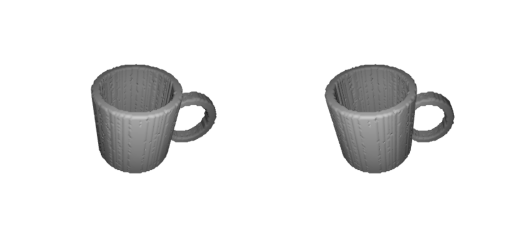

In [9]:
# https://pyrender.readthedocs.io/en/latest/examples/offscreen.html
# TODO: Calculate camera intrinsics

def render_mug(renderer):
    demo_cup = trimesh.load(osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj'))
    rot1 = np.eye(4)
    rot1[:3, :3] = util.make_rotation_matrix('x', np.pi / 2)
    demo_cup.apply_transform(rot1)

    mesh = pyrender.Mesh.from_trimesh(demo_cup)

    scene_l = pyrender.Scene()
    scene_r = pyrender.Scene()

    scene_l.add(mesh)
    scene_r.add(mesh)

    # Perspective camera is prob more realistic
    camera_l = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
    camera_r = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)

    # # Orthographic camera may be easier to deal with
    # camera_l = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)
    # camera_r = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)

    s = np.sqrt(2)/2
    center_offset = 0.1
    camera_l_pose = np.array([
        [0.0, -s,   s,   0.9],
        [1.0,  0.0, 0.0, -center_offset],
        [0.0,  s,   s,   0.9],
        [0.0,  0.0, 0.0, 1.0],
    ])
    camera_r_pose = np.array([
        [0.0, -s,   s,   0.9],
        [1.0,  0.0, 0.0, center_offset],
        [0.0,  s,   s,   0.9],
        [0.0,  0.0, 0.0, 1.0],
    ])
    scene_l.add(camera_l, pose=camera_l_pose)
    scene_r.add(camera_r, pose=camera_r_pose)

    light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                                innerConeAngle=np.pi/16.0,
                                outerConeAngle=np.pi/6.0)

    scene_l.add(light, pose=camera_l_pose)
    scene_l.add(light, pose=camera_r_pose)

    scene_r.add(light, pose=camera_l_pose)
    scene_r.add(light, pose=camera_r_pose)

    color_l, depth_l = renderer.render(scene_l)
    color_r, depth_r = renderer.render(scene_r)

    return color_l, color_r


renderer = pyrender.OffscreenRenderer(400, 400)

color_l, color_r = render_mug(renderer)
renderer.delete()  # Close the renderer to prevent EGL error

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color_l)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(color_r)
# plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()


# Test rendering speed

In [10]:
renderer = pyrender.OffscreenRenderer(400, 400)

pbar = tqdm(range(100))
for i in pbar:
    render_mug(renderer)

renderer.delete()  # Close the renderer to prevent EGL error

 37%|███▋      | 37/100 [00:25<00:43,  1.45it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

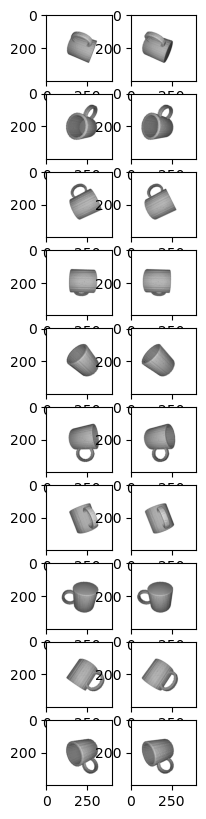

In [9]:
# Page 14ish of this is very helpful
# https://readthedocs.org/projects/pyrender/downloads/pdf/stable/
# https://www.brainvoyager.com/bv/doc/UsersGuide/CoordsAndTransforms/SpatialTransformationMatrices.html
def faster_render_mug(renderer, scene):
    demo_cup = trimesh.load(osp.join(data_dir, 'objects/mug_centered_obj/', shapenet_id, 'models/model_128_df.obj'))
    rot1 = np.eye(4)
    rot1[:3, :3] = util.make_rotation_matrix('x', np.pi / 2)
    demo_cup.apply_transform(rot1)

    mesh = pyrender.Mesh.from_trimesh(demo_cup)


    mesh_node = scene.add(mesh)

    # Perspective camera is prob more realistic
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
    # camera_r = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)

    # # Orthographic camera may be easier to deal with
    # camera_l = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)
    # camera_r = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)

    s = np.sqrt(2)/2
    center_offset = 0.1
    camera_l_pose = np.array([
        [0.0, -s,   s,   0.9],
        [1.0,  0.0, 0.0, -center_offset],
        [0.0,  s,   s,   0.9],
        [0.0,  0.0, 0.0, 1.0],
    ])
    camera_r_pose = np.array([
        [0.0, -s,   s,   0.9],
        [1.0,  0.0, 0.0, center_offset],
        [0.0,  s,   s,   0.9],
        [0.0,  0.0, 0.0, 1.0],
    ])

    ori_mug_pose = scene.get_pose(mesh_node)
    scaling_mat = np.array([
        [2.0, 0.0, 0.0, 0.0],
        [0.0, 2.0, 0.0, 0.0],
        [0.0, 0.0, 2.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ])

    scale_mug_pose = scaling_mat @ ori_mug_pose

    light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                                innerConeAngle=np.pi/16.0,
                                outerConeAngle=np.pi/6.0)

    scene.add(light, pose=camera_l_pose)
    scene.add(light, pose=camera_r_pose)

    l_cam_node = scene.add(camera, pose=camera_l_pose)
    r_cam_node = scene.add(camera, pose=camera_r_pose)
    color_l_images = []
    color_r_images = []
    for i in range(10):
        random_pose = np.eye(4)
        random_pose[:3, :3] = R.random().as_matrix()
        scene.set_pose(mesh_node, pose=random_pose)
        # if i % 2:
        #     scene.set_pose(mesh_node, pose=scale_mug_pose)
        # else:
        #     scene.set_pose(mesh_node, pose=ori_mug_pose)

        scene.main_camera_node = l_cam_node
        color_l, depth_l = renderer.render(scene)
        scene.main_camera_node = r_cam_node
        color_r, depth_r = renderer.render(scene)

        # # r_cam_node = scene.add(camera, pose=camera_r_pose)
        # # scene.main_camera_node = r_cam_node
        # color_r, depth_r = renderer.render(scene)
        color_l_images.append(color_l)
        color_r_images.append(color_r)
        # print('set')

    scene.clear()

    return color_l_images, color_r_images

scene = pyrender.Scene()
renderer = pyrender.OffscreenRenderer(400, 400)
color_l_images, color_r_images = faster_render_mug(renderer, scene)
renderer.delete()  # Close the renderer to prevent EGL error

plot = True 
if plot:
    n = len(color_l_images)
    plt.figure()
    figs, axes = plt.subplots(n, 2, figsize=(2 * 1, n * 1))
    for i in range(n):
        axes[i, 0].imshow(color_l_images[i])
        axes[i, 1].imshow(color_r_images[i])
    # plt.subplot(1,2,1)
    # plt.axis('off')
    # plt.imshow(color_l)
    # plt.subplot(1,2,2)
    # plt.axis('off')
    # plt.imshow(color_r)
    # plt.imshow(depth, cmap=plt.cm.gray_r)
    plt.show()


In [35]:
renderer = pyrender.OffscreenRenderer(400, 400)
scene = pyrender.Scene()

pbar = tqdm(range(100))
for i in pbar:
    faster_render_mug(renderer, scene)

renderer.delete()  # Close the renderer to prevent EGL error

  2%|▏         | 2/100 [00:26<21:33, 13.20s/it]


KeyboardInterrupt: 